## Open FDA exploratory notebook



In [15]:
import requests
import os
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import time
from joblib import delayed, Parallel
import datetime
# helper functions:
import helpers
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

import folium
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

%matplotlib inline

### Helper functions:

In [2]:
def country_convert(s):
    
    if s =='YU':
        
        s = 'Yugoslavia'
    try:
        s = coco.convert(s, to ='short_name')
    
    except:
        pass
    
    return(s)




def days_between(d1, d2):
    
    if np.isnan(d1) or np.isnan(d2):
        
        return np.nan

    else:
    
        d1 = str(int(d1))

        d2 = str(int(d2))

    if len(d1) == 6:
        
        d1 = d1+'01'
        
    elif len(d1) == 4:
        
        d1 = d1 +'0101'
        
    if len(d2) == 6:

        d2 = d2+'01'

    elif len(d2) == 4:

        d2 = d2 +'0101'
    
    try:
        
        d1 = datetime.datetime.strptime(d1, "%Y%m%d")
        d2 = datetime.datetime.strptime(d2, "%Y%m%d")
    
        return abs((d2 - d1).days)
    except:
        return np.nan


================================================================================================================================================================================================
### Let's get a sense of the sample data:

- The sample of data we pulled has 63800 rows and 85 columns, with event dates ranging from January 2010 to March 2020. Note: the total data set consists of over 1.2 million records, so the data we are working with here is only a small representation of the complete picture

- There are quite a few columns with incomplete data, we'll need to do some data QC to select more useful features

- While some data is not missing, they may still be non-informative if e.g. there is only 1 unique value



### Read in data pulled from the API:

In [3]:
data = pd.read_csv('openFDA_data/data/combined_weekly_sample_20200515.csv');

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,23,29,31,41,55,62,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.shape

(63800, 81)

### How many variables are missing data?

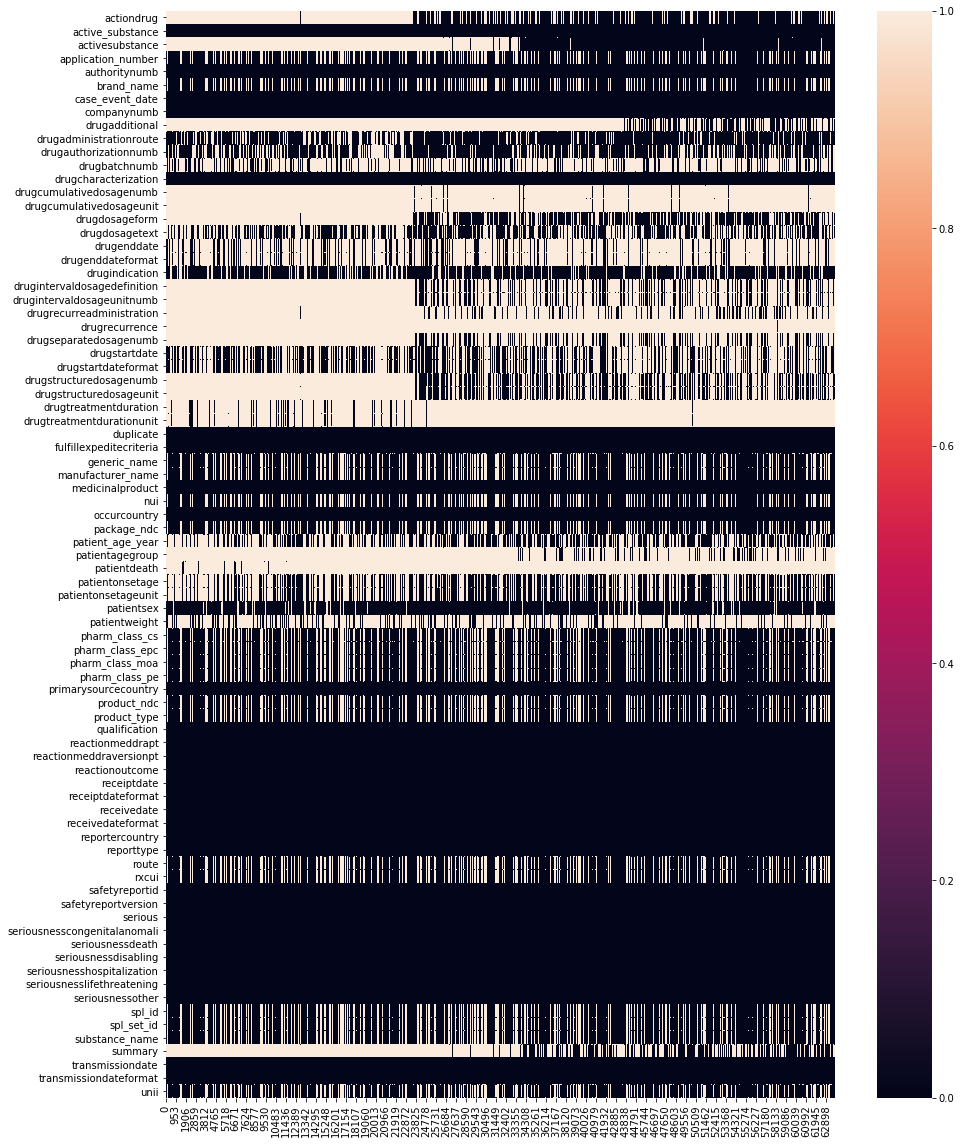

In [5]:
plt.figure(figsize=(15,20))
missing_data_count = sns.heatmap(data.isnull().transpose(), cbar = True)
plt.savefig('missing_data_count.png')
#sns.barplot(data_var)
#missing_data_count.savefig("missing_data_count.png")

### How many unique levels there are across the variables?

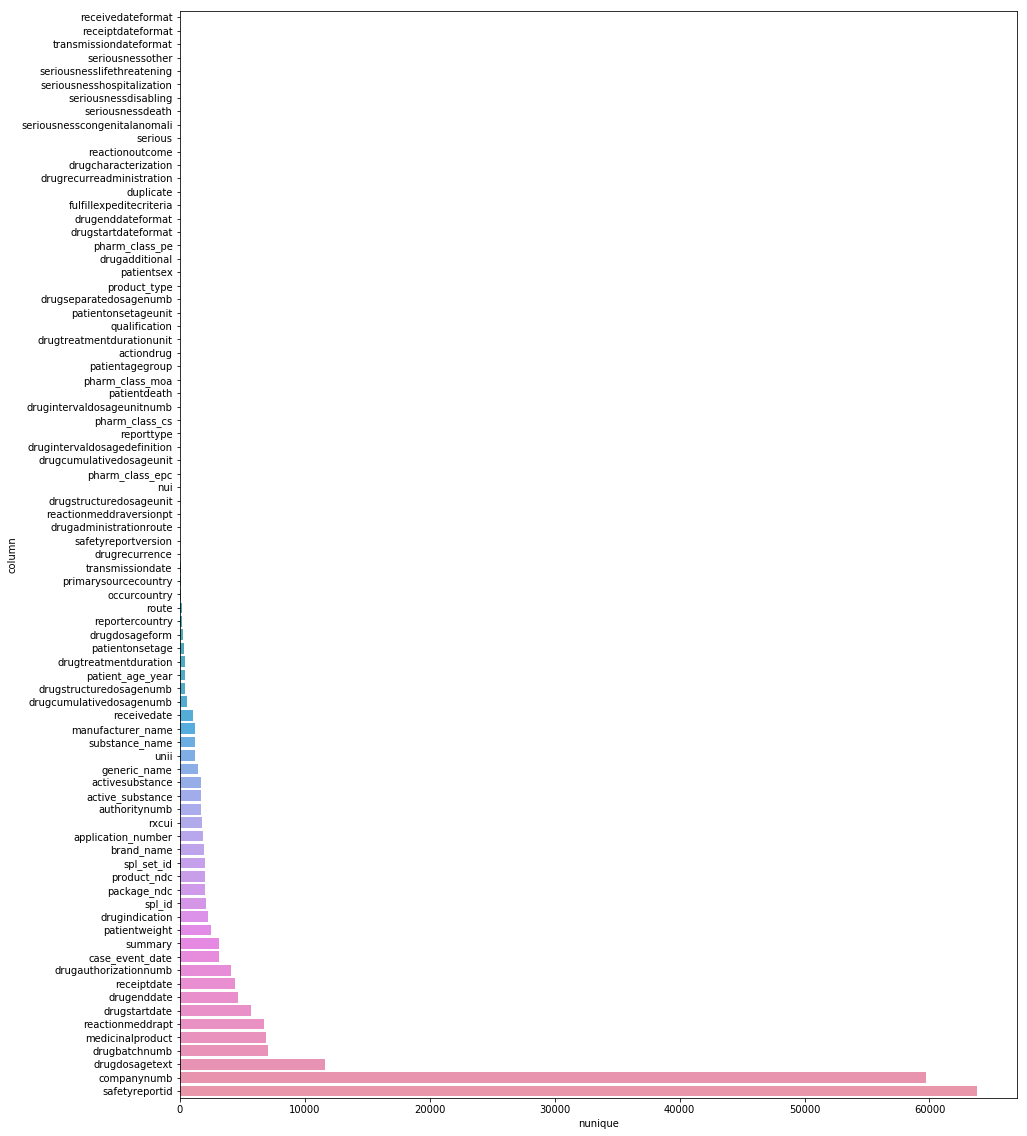

In [6]:
unique_levels = pd.DataFrame(data = {'column':data.columns,'nunique':data.nunique()}).sort_values('nunique')
plt.figure(figsize=(15,20))
sns.barplot(data=unique_levels, y ='column', x='nunique')
plt.savefig('unique_levels.png')

================================================================================================================================================================================================

### Data cleaning:

Horizontal (column): by dropping a feature using the following criteria:

- % of missing data > 80%

- has only 1 unique level

- represents a nested key (those were already unested in the previous data gathering function so information should be contained in other columns)




### Additional feature generation:

- patient age in years
- drug duration (taken as difference between `drugstartdate` and `drugenddate`, if exists
- lat and lon of reporter countries

In [ ]:

countries = data_subset['reportercountry'].unique()

countries_short = [country_convert(val) for val in countries]

country_lookup = pd.DataFrame(data = {'reportercountry':countries,'country_short':countries_short})

from geopy.geocoders import Nominatim
geolocator = Nominatim()
#import numpy as np

locs = [geolocator.geocode(c) for c in country_lookup['country_short']]

lat = [locs[i].latitude if locs[i] is not None else np.NaN for i in range(0,len(country_lookup))]
lon = [locs[i].longitude if locs[i] is not None else np.NaN  for i in range(0,len(country_lookup))]
country_lookup['lat'] = lat
country_lookup['lon'] = lon

In [7]:
missing_df = data.isnull()

missing_df_info = pd.DataFrame(data = {'missing_count':missing_df[missing_df==True].count(axis=0)/len(data)})


nested_keys = ['primarysource','sender','patient','receiver','reportduplicate','summary','patientdeath']
informative_vars1 = [val for val in set(missing_df_info[missing_df_info['missing_count']<0.8].index) - set(nested_keys) ]

informative_vars2 = [val for val in unique_levels[unique_levels['nunique']>1].index]

informative_vars = [val for val in informative_vars1  or informative_vars2]

data_subset = data[informative_vars]

data_subset['serious'] = data_subset['serious'].apply(lambda s : 1 if s ==1 else 0)

# add country information:
country_lookup = pd.read_csv('country_lookup.csv')

data_subset = data_subset.merge(country_lookup)

country_count = data_subset['country_short'].value_counts(ascending = False).reset_index()

country_count.columns = ['country_short','country_short_count']


data_subset = data_subset.merge(country_count)

drug_duration = [ days_between(data_subset['drugstartdate'][i],data_subset['drugenddate'][i]) for i in range(0,len(data_subset))]


# add drug duration:
data_subset['drug_duration'] = drug_duration


active_sub_count = data_subset['active_substance'].value_counts().reset_index()

active_sub_count.columns = ['active_substance','active_substance_count']

medicinalproduct_count = data_subset['medicinalproduct'].value_counts().reset_index()

medicinalproduct_count.columns = ['medicinalproduct','medicinalproduct_count']

data_subset = data_subset.merge(active_sub_count).merge(medicinalproduct_count)



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [8]:
len(data_subset['patient_age_year'].dropna())

32506

### Let's take a look at the variables that got removed:

In [9]:
set(data.columns) - set(informative_vars)

{'drugadditional',
 'drugcumulativedosagenumb',
 'drugcumulativedosageunit',
 'drugrecurreadministration',
 'drugrecurrence',
 'drugtreatmentduration',
 'drugtreatmentdurationunit',
 'patientagegroup',
 'patientdeath',
 'summary'}

================================================================================================================================================================================================
## Now some data analysis to answer some high level questions:

### Overview: can we use the data to get some useful answers such as the following?


    
- **Adverse events**

    - how often do we see an adverse events reported in this sample of data?
    - how wide-spread are these adverse events across countries?
    - given they are serious adverse events, what are the main reactions associated with it?

- **Product** 

    - what type of products are there?
    - what are the most common active ingredients?
    - which products are most associated with an adverse event?
    
- **Patient**

    - what are the age and gender of the patients?
    - how long did they typically take the drug before a reaction happens?
    - what are some of the reactions associated with adverse events?
    - do we see these reactions more often in certain age group or gender?



### More helper functions on data analysis and visualization:

In [10]:
def get_sample_rank(data_subset,col,pivot_value = 'serious'):
    col_count = str(col)+'_count'
    if col_count in data_subset.columns:
        
        strat_sample = data_subset[(data_subset[col_count]>200) & (data_subset[col]!='None')].groupby(col).apply(lambda d: d.sample(100))


        strat_sample.reset_index(drop=True, inplace = True)

        return strat_sample.pivot_table(values=pivot_value, index=col).reset_index().sort_values(pivot_value,ascending=False)
    else:
        return None
    
def compile_bootstrap(data_subset,col,pivot_value = 'serious',n=100, plot = True):
    
    bootstrap_samples = pd.concat(Parallel(n_jobs= -1)(delayed(get_sample_rank)(data_subset=data_subset,col=col,pivot_value=pivot_value) for i in np.arange(0,n)))
    
    if plot:
        plt.figure(figsize=(20,20))
        sns.boxplot(data = bootstrap_samples,  y = col , x = pivot_value)
        plt.title('Rate of '+ pivot_value + ' occurence based on ' + str(n)+' bootstrap samples of 100')
        plt.ylabel(col)
        plt.xlabel('Bootstrap rate')
        fig_name = col+'_'+pivot_value+'_'+ str(n)
        plt.savefig('figures/'+fig_name+'.png')
    
    bootstrap_median = bootstrap_samples.groupby(by=col).median().reset_index()
    
    bootstrap_median.columns = [col,'median']

    bootstrap_var = bootstrap_samples.groupby(by=col).var().reset_index()
    
    bootstrap_var.columns = [col,'var']
    

    return bootstrap_median.merge(bootstrap_var).sort_values('median',ascending = False)





def folium_map(data2, title = 'Rate of Life Theatening Conditions Across Countries',map_col = 'country', data_col = 'proportion', scale = 1000000):
    # Make an empty map
    m = folium.Map(location=[20, 0], zoom_start=3,width=1500,height=800)
    
    title_html = '''
             <h3 align="left" style="font-size:20px"><b>''' + title + '''</b></h3>'''
    m.get_root().html.add_child(folium.Element(title_html))


    for i in range(0,len(data2)):
           folium.Circle(
              location=[data2['lat'][i], data2['lon'][i]],
              popup= data2[map_col][i] + ': ' + str(round(100*data2[data_col][i],2))+ '%',
              radius=data2[data_col][i]*scale,
              color='crimson',
            fill = True,
            fill_color='crimson').add_to(m)
    return m



### Types of adverse events:

Let's see the breakdown of productions by adverse events:

From the metadata, we know that the flag `serious` indicates whether or not the adverse events result in serious conditions which are: death, a life threatening condition, hospitalization, disability, congenital anomaly, and other. 

In this sample, more than 50% of reports consist of serious adverse event.


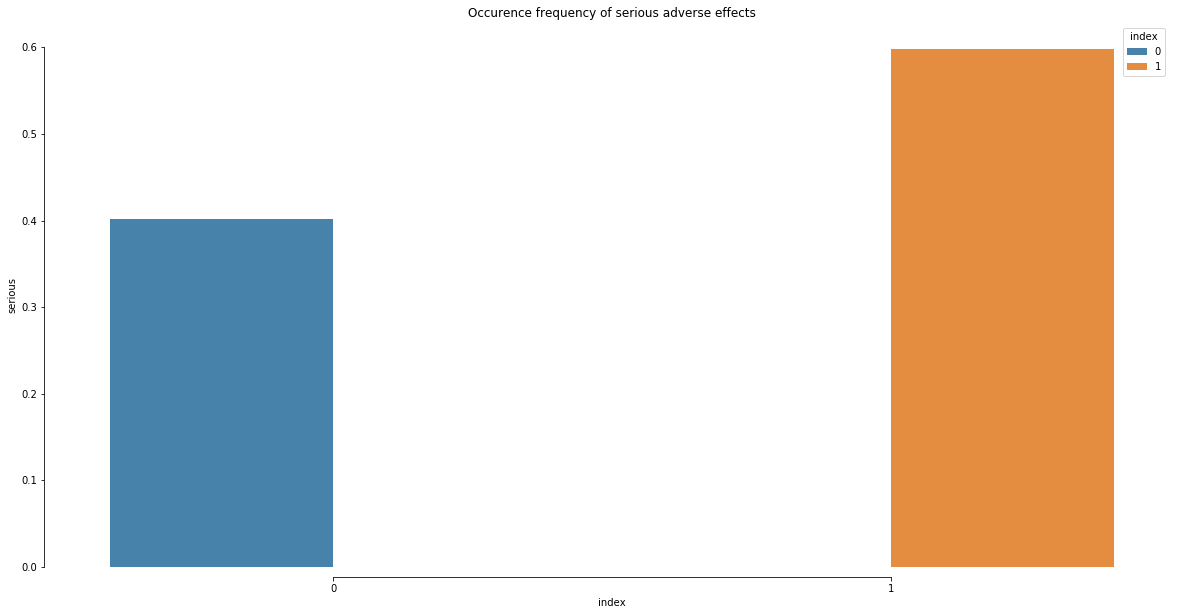

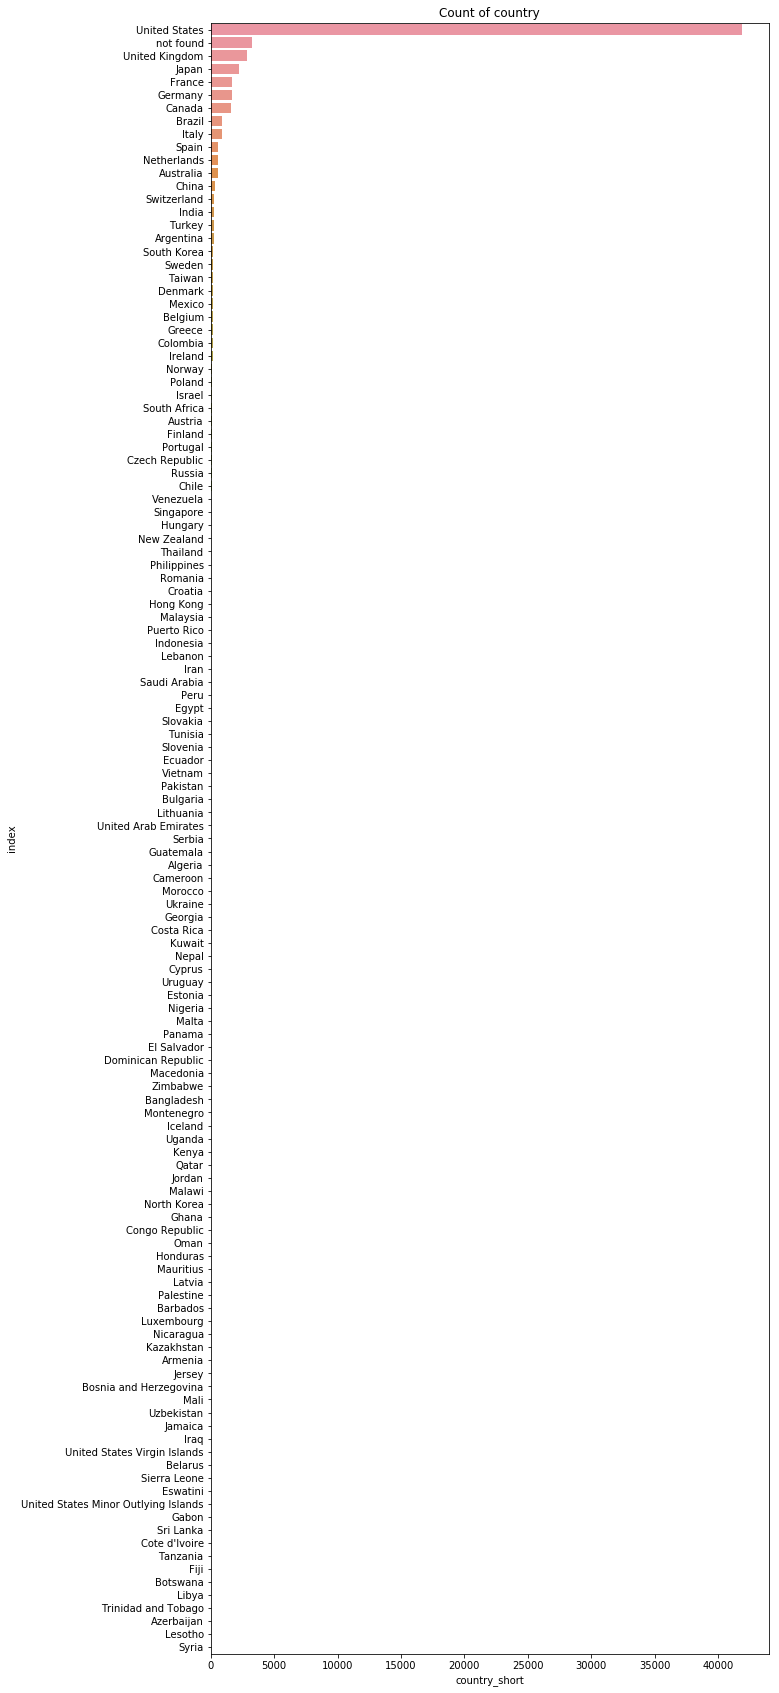

In [12]:
serious_flag = [val for val in data_subset.columns if 'serious' in val]
plt.figure(figsize=(20,10))
serious_pivot = data_subset[['country_short']+serious_flag].groupby(by='country_short').sum().reset_index().sort_values('seriousnesslifethreatening',ascending = False)
sns.set_color_codes("pastel")
g = sns.barplot(x = 'index', y = 'serious', 
                data = data_subset['serious'].value_counts('normalized').reset_index(), 
                hue ='index', alpha = 0.9);
new_title = 'Occurence frequency of serious adverse effects'
plt.title(new_title);
sns.despine(offset=10, trim=True);





plt.figure(figsize=(10,30))
sns.barplot(data = data_subset['country_short'].value_counts().reset_index(), x = 'country_short', y = 'index')
plt.title('Count of country');

### Mapping adverse event rate across countries:
In order to visualize adverse events on a map, we need to standardize country names and get geocode (lat/lon), also, since countries are represented in widely different number. A straight-forward comparison may not be fair, so let's try to offset the imbalance by inspecting the rate of serious adverse event using bootstrap samples.  Namely, we'll only show countries that have at least 200 cases, and we'll do a stratified sampling of 100 reports per country, then extract the rate of adverse events  

In [25]:
pivot_val = 'seriousnesshospitalization'
country_bootstrap = compile_bootstrap(data_subset = data_subset, col ='country_short',pivot_value=pivot_val,n=50,plot=False)

country_bootstrap_map = country_bootstrap.merge(country_lookup[['country_short','lat','lon']])



In [26]:
m = folium_map(data2 = country_bootstrap_map, title = 'Rate of serious adverse effects (countries with record > 100) that led to hospitalization',map_col='country_short', data_col='median',scale=200000)

path=pivot_val +'_by_country.html'
m.save(path)
m

### Medicinal products and active substance vs adverse events:

Are there certain active substances that appear more often with serious events? 

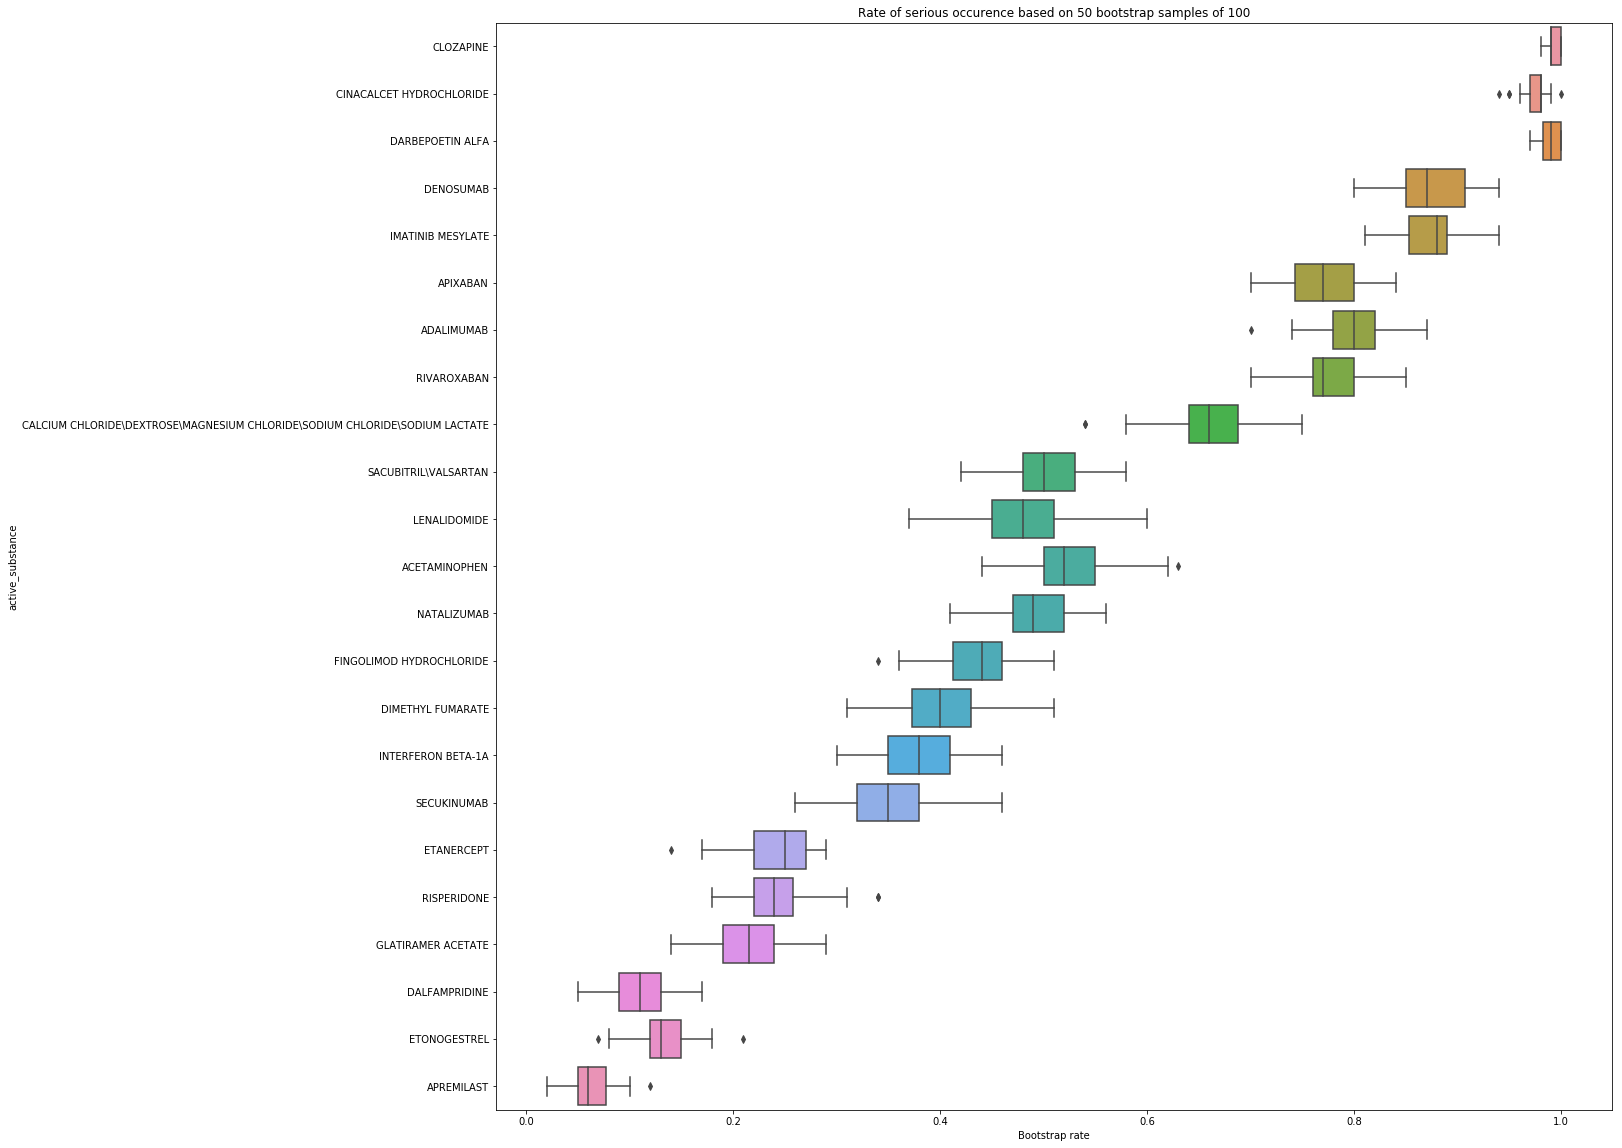

In [27]:
active_substance_bootstrap = compile_bootstrap(data_subset=data_subset, col ='active_substance',pivot_value='serious',n=50)

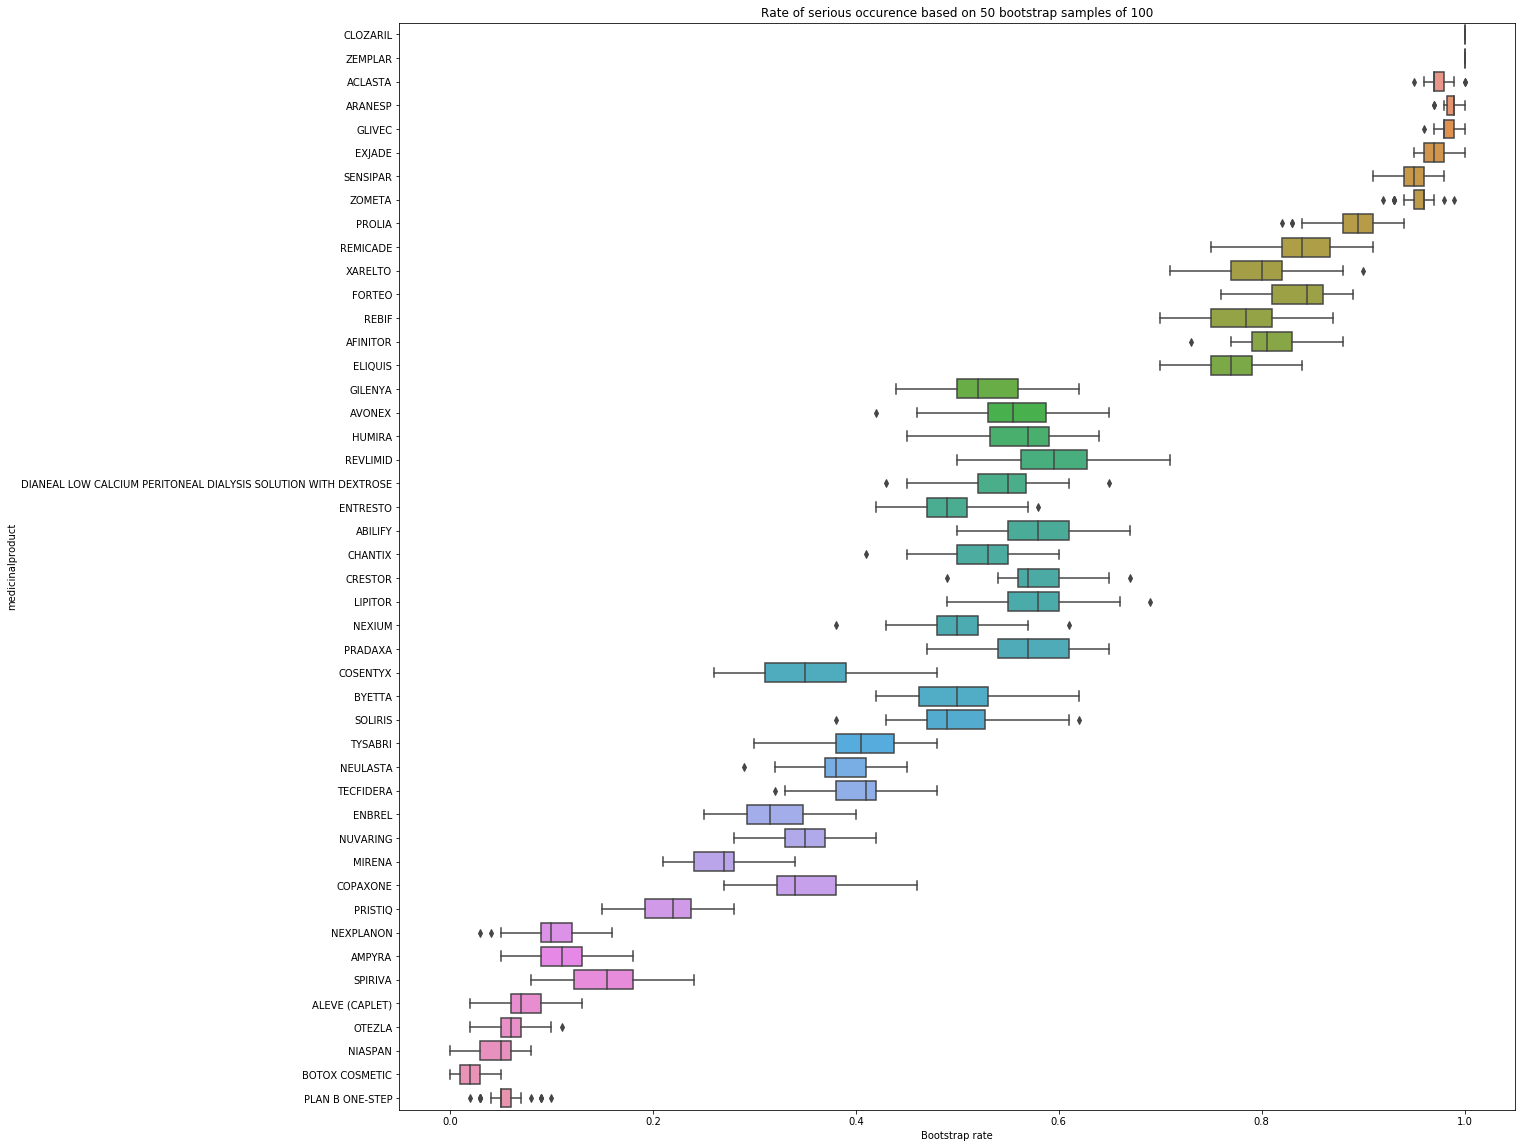

In [28]:
medicinal_product_bootstrap = compile_bootstrap(data_subset=data_subset, col ='medicinalproduct',pivot_value='serious',n=50)

### Can we cluster drugs together based on their similarity in reacions?

In [29]:
drug_reactions = pd.DataFrame()
    
for drug in medicinal_product_bootstrap['medicinalproduct'].unique():
    
    subset = data_subset[data_subset['medicinalproduct']==drug]
    reaction_list = str([r.lower() for r in subset['reactionmeddrapt']])
    drug_reactions = drug_reactions.append(pd.DataFrame(data = {'medicinalproduct':[drug], 'unique_reaction':[reaction_list]}))
    
drug_reactions.reset_index(inplace = True)    
    

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer().fit_transform(drug_reactions['unique_reaction'])

reaction_sim = tfidf * tfidf.T.toarray()

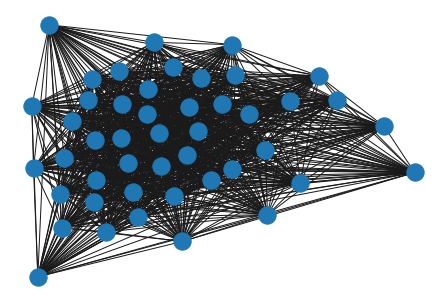

In [715]:
import networkx as nx
G = G=nx.from_numpy_matrix(reaction_sim)
nx.draw(G)

In [195]:
med_count = medicinalproduct_count[medicinalproduct_count['medicinalproduct'].isin(drug_reactions['medicinalproduct'])]
reaction_df = pd.DataFrame(reaction_sim, index = drug_reactions['medicinalproduct'],columns=drug_reactions['medicinalproduct']).reset_index().merge(med_count)
reaction_df.head()

drug_duration = data_subset[['medicinalproduct','drug_duration']].dropna().groupby('medicinalproduct').median().reset_index()

reaction_df = reaction_df.merge(drug_duration)
#len(reaction_df2)

#reaction_df2.head()

reaction_df['drug_duration_disc'] = [str(s) for s in pd.cut(reaction_df2['drug_duration'],10)]

In [196]:
reaction_df.shape

(46, 50)

In [ ]:
reaction_df[]

In [197]:
import networkx as nx
g = nx.Graph()
count = []
duration = []
nx.set_node_attributes(g, count, 'count')
nx.set_node_attributes(g, duration, 'duration_bracket')
drugs = [d for d in reaction_df['medicinalproduct']]

for i in range(0,len(reaction_df2)):
    drug = reaction_df['medicinalproduct'][i]
    duration = reaction_df['drug_duration_disc'][i]
    if drug in g:
        g.nodes[drug]["count"] = reaction_df['medicinalproduct_count'][i]
        g.nodes[drug]["duration_bracket"] = duration
    else:
        #g.add_node(drug, attr_dict={"count":reaction_df['medicinalproduct_count'][i]})
        g.add_node(drug)
        g.nodes[drug]["count"] = reaction_df['medicinalproduct_count'][i]
        g.nodes[drug]["duration_bracket"] = duration
        print(g)
        
    for j in range(1,len(drugs)):
        #print(j)
        
        weight = reaction_df[reaction_df.columns[j]][i]
        #print(weight)
        
        drug1 = reaction_df['medicinalproduct'][i]
        drug2 = reaction_df['medicinalproduct'][j]
        
        if (drug1 != drug2) & (float(weight) > 0.3) :
            
            if g.has_edge(drug1, drug2):
                
                pass
  
            else:
        
                #g.add_weighted_edges_from(drug1, drug2, weight)
                    # Create a new link with strength 1
                g.add_edge(drug1, drug2, attr_dict={"weight":weight},length = 10*weight)
        
            

    neighbourless_drugs = []
    
    neighbourless_drugs = []
    for drug in g.nodes():

        if len(list(g.neighbors(drug))) == 0:

            neighbourless_drugs.append(drug)

    for drug in neighbourless_drugs:
        g.remove_node(drug)
                       

In [227]:
g.nodes

NodeView(('ZEMPLAR', 'CLOZARIL', 'GLIVEC', 'EXJADE', 'ACLASTA', 'ZOMETA', 'FORTEO', 'XARELTO', 'REVLIMID', 'TECFIDERA', 'OTEZLA', 'ARANESP', 'REMICADE', 'ABILIFY', 'PRADAXA', 'BYETTA', 'ENTRESTO', 'CHANTIX', 'SENSIPAR', 'PROLIA', 'ELIQUIS', 'CRESTOR', 'HUMIRA', 'AVONEX', 'DIANEAL LOW CALCIUM PERITONEAL DIALYSIS SOLUTION WITH DEXTROSE', 'TYSABRI', 'AFINITOR', 'COPAXONE', 'MIRENA', 'NEXPLANON', 'PLAN B ONE-STEP', 'REBIF', 'NEULASTA', 'ENBREL', 'LIPITOR', 'NEXIUM', 'SOLIRIS', 'GILENYA', 'SPIRIVA', 'NUVARING', 'PRISTIQ', 'ALEVE (CAPLET)', 'COSENTYX', 'AMPYRA', 'NIASPAN', 'BOTOX COSMETIC'))

In [235]:
g.get_edge_data('ZEMPLAR', 'CLOZARIL')['attr_dict']['weight']

0.9999999999999998

In [203]:
duration_bracket = [g.nodes[d]['duration_bracket'] for d in g.nodes()]
palette_map = {duration:hex_palette[i] for i, duration in enumerate(duration_bracket )}
palette_map

{'(292.2, 438.3]': '#8495f4',
 '(438.3, 584.4]': '#9a8ff4',
 '(584.4, 730.5]': '#f7745a',
 '(146.1, 292.2]': '#f45af3',
 '(876.6, 1022.7]': '#35aca4',
 '(-1.461, 146.1]': '#f66e9a',
 '(1314.9, 1461.0]': '#ac88f4'}

In [258]:
sizes = []

In [309]:
from bokeh.plotting import *
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.io import output_notebook, save
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx
from bokeh.models import ColumnDataSource, LabelSet
view_in_notebook = True
palette = sns.color_palette("husl", len(g.nodes))
sizes = []
# The above palette is given in RGB [0-1] range
# bokeh requires colours be defined in hex RGB
hex_palette = ["#%02x%02x%02x" % (int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in palette]

duration_bracket = [g.nodes[d]['duration_bracket'] for d in g.nodes()]

palette_map = {duration:hex_palette[i] for i, duration in enumerate(duration_bracket )}
#palette_map = {moa:hex_palette[i] for i, moa in enumerate(set(g.nodes))}


pos = nx.layout.spring_layout(g, iterations=1000)
    
    # ---------------------------
    
    # Determine appearance of nodes, representing drugs
xs, ys, colours, labels, sizes = [], [], [], [], []

for i, (node_name, coords) in enumerate(pos.items()):
    #print(node_name)

    # X and Y co-ordinates of the drug
    xs.append(coords[0])
    ys.append(coords[1])

    # Method of action used for colour and label
    col = node_name#['attr_dict']["count"]
    
    d = g.nodes[node_name]['duration_bracket']
    colours.append(palette_map[d])

    label = node_name + ',\n median duration range:' + d + ',\n count :' + str(count)
    labels.append(label)
    count = g.nodes[node_name]["count"]
    #sizes.append(count)
    sizes.append(25)

#    print(sizes)
    #print(sizes)
    
    
node_source = ColumnDataSource(data=dict(x=xs, y=ys, label=labels, color=colours, size=sizes))
    
    # Determine appearance of lines representing co-occurence in events
xlist, ylist, weight = [], [], []

for node_A, node_B, data in g.edges(data=True):

    x1, y1 = pos[node_A]
    x2, y2 = pos[node_B]

    xlist += [x1, x2, float("NaN")]
    ylist += [y1, y2, float("NaN")]
    #weight += [100*data['attr_dict']["weight"]]
    #weight += [get_weight(g,node_A,node_B)]

line_source = ColumnDataSource(data=dict(xs=xlist, ys=ylist))#, line_width=weight))

# ---------------------------

if view_in_notebook:
    output_notebook(hide_banner=True)

f1 = figure(plot_width=900, plot_height=900, tools="pan,wheel_zoom,box_zoom,reset,hover")

f1.grid.grid_line_width = 0
f1.axis.visible = False

# Draw the lines between nodes
f1.line(x="xs", y="ys", line_width=0.5, source=line_source, color="#000000", line_alpha=0.35)

# Draw the nodes
f1.circle("x", "y", source=node_source, name="node", size="size", color="color", line_width=0.5, line_alpha=0.75, line_color="#000000")

# Attach the HoverTool to the drug nodes to display their label
hover = f1.select(dict(type=HoverTool))
hover.tooltips = """<div> @label </div>"""
hover.point_policy = "snap_to_data"
hover.names = ["node"]

# Legend

f1.title.text = "Network visualization of drugs based on similarity of reactions and median duration until adverse events"
f1.title.align = "center"
f1.title.text_color = "grey"
f1.title.text_font_size = "14px"

text = [index for _,index in enumerate(palette_map)]

colors = [palette_map[index] for _,index in enumerate(palette_map)]

x_pos = [0+0.05*i for i in range(0,len(colors))] 
y_pos = [1 for i in range(0,len(colors))] 
size_legend = [12 for i in range(0,len(colors))]

f1.circle(x_pos, y_pos, size=size_legend, line_width=0.5, line_alpha=0.75, line_color="#000000", color=colors,)
f1.text(x_pos, y_pos, text=text, text_align="center", text_font_size="8pt",angle = 45)

#show(f1)
if view_in_notebook:
    show(f1)
else:
    filename = save(f1, filename="network.html", title="Network visualization of drugs based on similarity of reactions and median duration until adverse events")

In [300]:
?f1.legend

Type:        property
String form: <property object at 0x1a230dd908>
Docstring:  
Splattable list of :class:`~bokeh.models.annotations.Legend` objects.

        


In [286]:
[palette_map[index] for _,index in enumerate(palette_map)]

['#8495f4', '#9a8ff4', '#f7745a', '#f45af3', '#35aca4', '#f66e9a', '#ac88f4']

In [239]:
def get_weight(g,n1,n2):
    try:
        return g.get_edge_data(n1, n2)['attr_dict']['weight']
    except:
        return 0

In [70]:
def draw_graph(g, view_in_notebook=True):
    """Produce an interactive visualisation of a Graph.
    
    g -- (Graph) the graph to draw
    view_in_notebook -- (boolean) If True, the interactive chart will be displayed inline in the notebook. If False, it will be saved to an external file.
    """
    

    palette = sns.color_palette("husl", len(g.nodes))

    # The above palette is given in RGB [0-1] range
    # bokeh requires colours be defined in hex RGB
    hex_palette = ["#%02x%02x%02x" % (int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in palette]

    # Map each MoA to a hex colour (string:string)
    palette_map = {moa:hex_palette[i] for i, moa in enumerate(set(g.nodes))}
    #palette_map["-"] = "#F5F5F5"
    
    # Fruchterman-Reingold algorithm to determine node positions
    # Uses "weight" edge property (higher weight = closer)
    # TODO: Replace with force_atlas2 algorithm which is much better
    pos = nx.layout.spring_layout(g, iterations=1000)
    
    # ---------------------------
    
    # Determine appearance of nodes, representing drugs
    xs, ys, colours, labels, sizes = [], [], [], [], []

    for i, (node_name, coords) in enumerate(pos.items()):

        # X and Y co-ordinates of the drug
        xs.append(coords[0])
        ys.append(coords[1])

        # Method of action used for colour and label
        moa = g.nodes[node]["count"]
        colours.append(palette_map[moa])

        # Sometimes the MoA isn't given, we use "-"
        if moa == "-":
            label = node_name
        else:
            label = "{} ({})".format(node_name, moa)
        labels.append(label)

        # Size of node increases with count
        # count is incremented for each appearance in an event
        # TODO: Dynamic scaling based on range of "count" in the graph
        sizes.append(min(25, 7 + g.nodes[node_name]["count"]))


    node_source = ColumnDataSource(data=dict(x=xs, y=ys, label=labels, color=colours, size=sizes))
    
    # Determine appearance of lines representing co-occurence in events
    xlist, ylist, weight = [], [], []

    for node_A, node_B, data in g.edges(data=True):

        x1, y1 = pos[node_A]
        x2, y2 = pos[node_B]

        xlist += [x1, x2, float("NaN")]
        ylist += [y1, y2, float("NaN")]
        weight += [data['attr_dict']["weight"]]

    line_source = ColumnDataSource(data=dict(xs=xlist, ys=ylist, line_width=weight))
    
    # ---------------------------

    if view_in_notebook:
        output_notebook(hide_banner=True)

    f1 = figure(plot_width=900, plot_height=900, tools="pan,wheel_zoom,box_zoom,reset,hover")

    f1.grid.grid_line_width = 0
    f1.axis.visible = False

    # Draw the lines between nodes
    f1.line(x="xs", y="ys", line_width=0.35, source=line_source, color="#000000", line_alpha=0.35)

    # Draw the nodes
    f1.circle("x", "y", source=node_source, name="node", size="size", color="color", line_width=0.5, line_alpha=0.75, line_color="#000000")

    # Attach the HoverTool to the drug nodes to display their label
    hover = f1.select(dict(type=HoverTool))
    hover.tooltips = """<div> @label </div>"""
    hover.point_policy = "snap_to_data"
    hover.names = ["node"]

    # Legend
    f1.circle([0, 0.05, 0.1, 0.15], [1, 1, 1, 1], size=[7, 12, 17, 22], line_width=0.5, line_alpha=0.75, line_color="#000000", color="#F0F0F0")
    f1.text(x=[0, 0.05, 0.1, 0.15], y=[1.02, 1.02, 1.02, 1.02], text=["1", "10", "15", "20 events"], text_align="center", text_font_size="6pt")

    if view_in_notebook:
        show(f1)
    else:
        filename = save(f1, filename="network.html", title="Network of drugs in shared events")

In [71]:
draw_graph(g, view_in_notebook=True)

KeyError: 'count'

In [786]:
elarge=[(u,v) for (u,v,d) in g.edges(data=True) if d['attr_dict']['weight'] == 1]

In [787]:
g.add_weighted_edges_from

[('ARANESP', 'GLIVEC'),
 ('GLIVEC', 'EXJADE'),
 ('SENSIPAR', 'PROLIA'),
 ('PROLIA', 'REMICADE'),
 ('FORTEO', 'AFINITOR'),
 ('AFINITOR', 'XARELTO'),
 ('ABILIFY', 'LIPITOR'),
 ('ENTRESTO', 'TYSABRI'),
 ('TECFIDERA', 'NEULASTA'),
 ('ENBREL', 'MIRENA')]

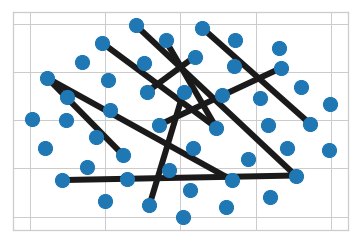

In [780]:

esmall=[(u,v) for (u,v,d) in g.edges(data=True) if d['attr_dict']['weight'] <=5]

pos=nx.spring_layout(g) # positions for all nodes

# nodes
nx.draw_networkx_nodes(g,pos,node_size=200)

# edges
nx.draw_networkx_edges(g,pos,edgelist=elarge,
                    width=6)
#nx.draw_networkx_edges(g,pos,edgelist=esmall,
#                    width=6,alpha=0.5,edge_color='b',style='dashed')

In [747]:
g.nodes

NodeView(('ZEMPLAR', 'CLOZARIL', 'ARANESP', 'GLIVEC', 'EXJADE', 'ACLASTA', 'ZOMETA', 'SENSIPAR', 'PROLIA', 'REMICADE', 'FORTEO', 'AFINITOR', 'XARELTO', 'REBIF', 'ELIQUIS', 'REVLIMID', 'ABILIFY', 'LIPITOR', 'PRADAXA', 'CRESTOR', 'AVONEX', 'DIANEAL LOW CALCIUM PERITONEAL DIALYSIS SOLUTION WITH DEXTROSE', 'HUMIRA', 'GILENYA', 'CHANTIX', 'NEXIUM', 'SOLIRIS', 'BYETTA', 'ENTRESTO', 'TYSABRI', 'TECFIDERA', 'NEULASTA', 'COSENTYX', 'COPAXONE', 'NUVARING', 'ENBREL', 'MIRENA', 'PRISTIQ', 'SPIRIVA', 'AMPYRA', 'NEXPLANON', 'ALEVE (CAPLET)', 'OTEZLA', 'PLAN B ONE-STEP', 'NIASPAN', 'BOTOX COSMETIC'))

In [750]:
#g.add_edges_from('ZEMPLAR','CLOZARIL')


g.add_edge('ZEMPLAR','CLOZARIL',attr_dict= {"weight": 10*0.26})

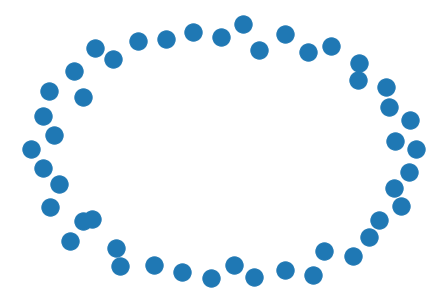

In [751]:
nx.draw(g)

In [ ]:
def build_graph(reaction):
    """Construct a Graph object from a list of drug adverse events.
    
    cases -- (list) A list of drug adverse events.
    """
    
    g = nx.Graph()

    for case in cases:

        # First, loop through all drugs to guarantee each has a node in the graph
        for drug in case["patient"]["drug"]: 

            node_name = determine_drug_identity(drug)

            # The openfda attribute is optional
            try:
                moa = drug["openfda"]["pharm_class_moa"][0]
                moa = moa.replace(" [MoA]", "")
            except:
                moa = "-"

            if node_name in g:
                g.nodes[node_name]["attr_dict"]["count"] += 1
            else:
                g.add_node(node_name, attr_dict={"moa":moa, "count":1})

        # Second, add a connection between each pair of drugs in this case
        for drug_A in case["patient"]["drug"]: 

            for drug_B in case["patient"]["drug"]: 

                if drug_A != drug_B:

                    node_name_A = determine_drug_identity(drug_A)
                    node_name_B = determine_drug_identity(drug_B)

                    # If the two drugs have coappeared in a case before
                    if g.has_edge(node_name_A, node_name_B):

                        # Strengthen the existing link
                         g[node_name_A][node_name_B]["attr_dict"]["weight"] += 1
                        #print('no')

                    else:
                        # Create a new link with strength 1
                        g.add_edge(node_name_A, node_name_B, attr_dict={"weight":1})
                        
    #Remove any drugs that never co-occurred in a case
    neighbourless_drugs = []
    
    neighbourless_drugs = []
    for drug in g.nodes():

        if len(list(g.neighbors(drug))) == 0:

            neighbourless_drugs.append(drug)

    for drug in neighbourless_drugs:
        g.remove_node(drug)

    return g